In [1]:
import sys


sys.path.append("..")
from pathlib import Path
from argparse import ArgumentParser
import torch as th
from src.diffusion.base import DiffusionSampler, _sample_x_t_given_x_0
from src.diffusion.beta_schedules import (
    improved_beta_schedule,
    linear_beta_schedule,
    respaced_beta_schedule,
)
from src.utils.net import get_device, Device
from src.model.guided_diff.unet import load_guided_diff_unet
from src.model.guided_diff.classifier import load_guided_classifier
from src.model.resnet import load_classifier_t
from src.model.unet import load_mnist_diff
from src.guidance.base import GuidanceSampler, MCMCGuidanceSampler
from src.guidance.classifier_full import ClassifierFullGuidance
from src.samplers.mcmc import AnnealedHMCScoreSampler, estimate_energy_diff_linear
from exp.utils import SimulationConfig, setup_results_dir, get_step_size
from src.utils.seeding import set_seed
from src.data.mnist import get_mnist_data_loaders
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

In [2]:
seed = 0
num_diff_steps = 1000
num_respaced_diff_steps = 1000
guid_scale = 1.0
mcmc_steps = 6


set_seed(seed)

device = get_device(Device.GPU)

# Check that all models exist
models_dir = Path.cwd() / '..' / "models"
diff_score_model_path = models_dir / f"score_uncond_unet_mnist.pt"
assert diff_score_model_path.exists(), f"Model '{diff_score_model_path}' does not exist."
diff_energy_model_path = models_dir / f"energy_uncond_unet_mnist.pt"
assert diff_energy_model_path.exists(), f"Model '{diff_energy_model_path}' does not exist."
classifier_path = models_dir / f"resnet_classifier_t_mnist.pt"
assert classifier_path.exists(), f"Model '{classifier_path}' does not exist."

channels, image_size = 1, 28
beta_schedule, post_var = improved_beta_schedule, "beta"
num_classes = 10
diff_model_score = load_mnist_diff(diff_score_model_path, device)
diff_model_energy = load_mnist_diff(diff_energy_model_path, device, energy=True)
classifier = load_classifier_t(model_path=classifier_path, dev=device)
classifier.eval()

betas, time_steps = respaced_beta_schedule(
    original_betas=beta_schedule(num_timesteps=num_diff_steps),
    T=num_diff_steps,
    respaced_T=num_respaced_diff_steps,
)
diff_sampler = DiffusionSampler(betas, time_steps, posterior_variance=post_var)
guidance = ClassifierFullGuidance(classifier, lambda_=guid_scale)

mcmc_sampler = AnnealedHMCScoreSampler(mcmc_steps, diff_sampler.betas, 0.9, diff_sampler.betas, 3, None)

guid_sampler_score = MCMCGuidanceSampler(
    diff_model=diff_model_score,
    diff_proc=diff_sampler,
    guidance=guidance,
    mcmc_sampler=mcmc_sampler,
    reverse=True,
    diff_cond=False)

guid_sampler_energy = MCMCGuidanceSampler(
    diff_model=diff_model_energy,
    diff_proc=diff_sampler,
    guidance=guidance,
    mcmc_sampler=mcmc_sampler,
    reverse=True,
    diff_cond=False)

dataloader_train, dataloader_val = get_mnist_data_loaders(1)

Using manual seed '0'


Found cached dataset mnist (/home/anders.sjoberg/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

## Energy Compare (2 samples at same t)

In [136]:
data_iter = iter(dataloader_train)
N = 20
ts_save = []
eds, ede, energy = {}, {}, {}
for i in tqdm(range(N)):
    data = next(data_iter)
    x0 = data['pixel_values'].to(device)
    y = data['label'].to(device)
    t = th.randint(0, num_diff_steps, (1,)).item()
    
    noise = th.randn_like(x0)
    ts = th.ones((1,), device=device).long() * t
    x_t_hat = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    noise = th.randn_like(x0)
    x_t = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    
    energy_diff = guid_sampler_energy.energy(x_t_hat, t, None, y) - guid_sampler_energy.energy(x_t, t, None, y)
    energy[i] = energy_diff.detach().cpu().item()
    ns = [5, 10, 15, 25, 35]
    eds_, ede_ = [], []
    for n in ns:
        ss = th.linspace(0, 1, steps=n).to(device)
        x_t_hat = x_t_hat.requires_grad_(True)
        x_t = x_t.requires_grad_(True)
        energy_diff_estimate = estimate_energy_diff_linear(guid_sampler_energy.grad_energy, x_t, x_t_hat, t, t, ss, y, x0.dim())
        energy_diff_estimate_score = estimate_energy_diff_linear(guid_sampler_score.grad_energy, x_t, x_t_hat, t, t, ss, y, x0.dim())
        ede_.append(energy_diff_estimate.detach().cpu().item())
        eds_.append(energy_diff_estimate_score.detach().cpu().item())
    eds[i] = eds_
    ede[i] = ede_

 30%|█████████████████████████▏                                                          | 6/20 [00:48<01:53,  8.12s/it]


KeyboardInterrupt: 

In [93]:
print('Percentage of positive energi difference: ', np.sum(np.array(list(energy.values())) > 0)/N)

Percentage of positive energi difference:  0.6


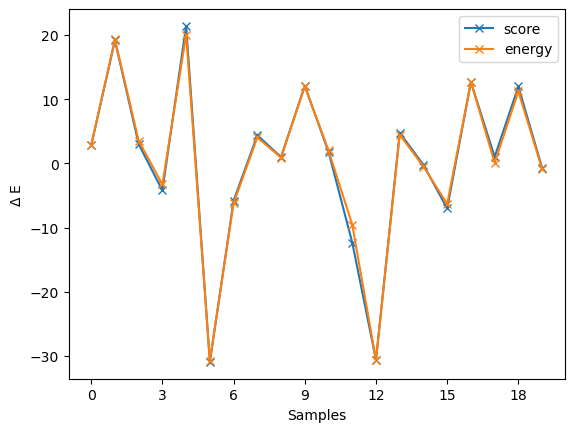

In [47]:
ax = plt.figure().gca()
plt.plot([v[-1] for v in eds.values()], 'x-', label='score')
plt.plot([v for v in energy.values()], 'x-', label='energy')
# plt.plot([v[-1] for v in ede.values()], label='energy')
plt.ylabel(r'$\Delta$ E')
plt.xlabel('Samples')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

Text(0.5, 0, 'Number of trapz-steps')

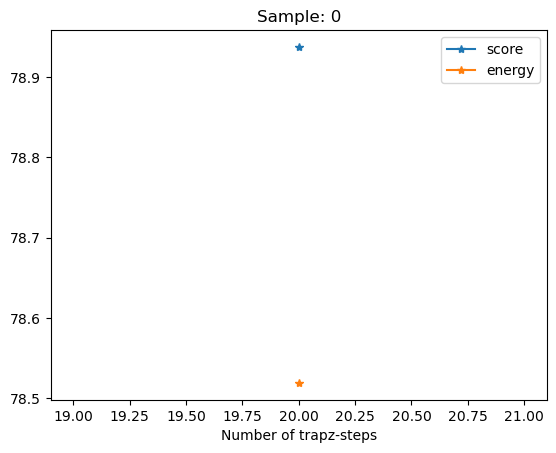

In [135]:
i = np.random.randint(N)
plt.figure()
plt.title('Sample: ' + str(i))
plt.plot(ns, eds[i], '*-', label='score')
plt.plot(ns, ede[i], '*-', label='energy')
plt.plot(ns, energy[i]*np.ones(len(ns)))
plt.legend()
plt.xlabel('Number of trapz-steps')

Text(0.5, 1.0, 'Residual between exakt and approximated energy')

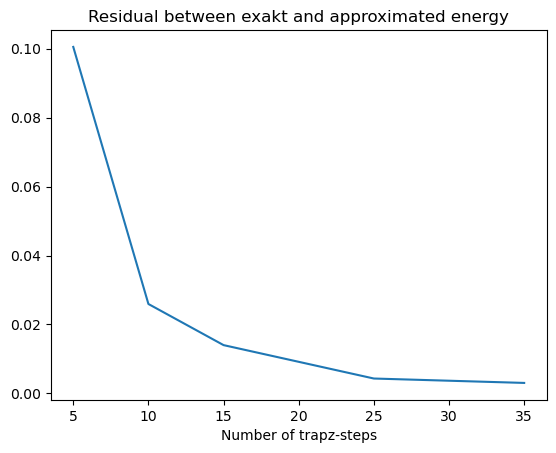

In [90]:
mean_ = [np.mean(np.abs(np.array([v for v in ede.values()])[:, i] - np.array([v for v in energy.values()]))) for i in range(len(ns))]
plt.figure()
plt.plot(ns, mean_)
plt.xlabel('Number of trapz-steps')
plt.title('Residual between exakt and approximated energy')

## Energy Compare (2 samples at same t-X and t)

In [148]:
data_iter = iter(dataloader_train)
N = 1
X = 50
ts_save = []
eds, ede, energy = {}, {}, {}
for i in tqdm(range(N)):
    data = next(data_iter)
    x0 = data['pixel_values'].to(device)
    y = data['label'].to(device)
    t = th.randint(X, num_diff_steps, (1,)).item()
    t_hat = t - X
    
    noise = th.randn_like(x0)
    ts_hat = th.ones((1,), device=device).long() * t_hat
    x_t_hat = diff_sampler.q_sample(x_0=x0, ts=ts_hat, noise=noise)
    noise = th.randn_like(x0)
    ts = th.ones((1,), device=device).long() * t
    x_t = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    
    energy_diff = guid_sampler_energy.energy(x_t, t_hat, None, y) - guid_sampler_energy.energy(x_t_hat, t_hat, None, y)
    energy[i] = energy_diff.detach().cpu().item()
    """
    ns = [20]
    eds_, ede_ = [], []
    for n in ns:
        ss = th.linspace(0, 1, steps=n).to(device)
        x_t_hat = x_t_hat.requires_grad_(True)
        x_t = x_t.requires_grad_(True)
        energy_diff_estimate = estimate_energy_diff_linear(guid_sampler_energy.grad_energy, x_t_hat, x_t, t_hat, t_hat, ss, y, x0.dim())
        energy_diff_estimate_score = estimate_energy_diff_linear(guid_sampler_score.grad_energy, x_t_hat, x_t, t_hat, t_hat, ss, y, x0.dim())
        ede_.append(energy_diff_estimate.detach().cpu().item())
        eds_.append(energy_diff_estimate_score.detach().cpu().item())
    eds[i] = eds_
    ede[i] = ede_
    """

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


In [142]:
t_hat

657

In [139]:
t

707

In [150]:
guid_sampler_energy.energy(x_t_hat, t_hat, None, y)

tensor([112.3964], device='cuda:0', grad_fn=<AddBackward0>)

In [149]:
guid_sampler_energy.energy(x_t, t_hat, None, y)

tensor([166.2421], device='cuda:0', grad_fn=<AddBackward0>)

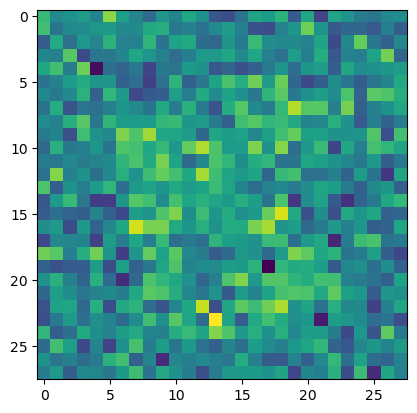

In [129]:
plt.imshow(x_t_hat.detach().cpu().squeeze())

In [141]:
[guid_sampler_energy.energy(x_t_hat, i, None, y).cpu().item() for i in np.arange(0, 1000, 10)]

[705.9931030273438,
 792.1541748046875,
 826.6652221679688,
 844.4664916992188,
 853.5360717773438,
 853.759033203125,
 854.0206909179688,
 848.3506469726562,
 842.353271484375,
 832.5469360351562,
 821.764404296875,
 814.9979248046875,
 802.3052978515625,
 785.1423950195312,
 770.7791748046875,
 758.2421875,
 752.85107421875,
 736.9614868164062,
 724.009033203125,
 707.9562377929688,
 692.7266845703125,
 680.5545043945312,
 667.7462768554688,
 652.2406616210938,
 640.81494140625,
 627.0059204101562,
 615.7564086914062,
 599.4053344726562,
 587.1519165039062,
 571.7796020507812,
 561.0091552734375,
 553.18994140625,
 539.5200805664062,
 531.4169311523438,
 522.22900390625,
 509.4651184082031,
 500.15753173828125,
 488.5003662109375,
 479.30316162109375,
 473.1480712890625,
 461.3736267089844,
 453.8928527832031,
 447.5557556152344,
 439.23004150390625,
 434.04876708984375,
 426.3462219238281,
 419.4873046875,
 413.0932922363281,
 405.7672424316406,
 401.1953125,
 394.14776611328125,
 3

In [147]:
print('Percentage of positive energi difference: ', np.sum(np.array(list(energy.values())) > 0)/N)

Percentage of positive energi difference:  0.55
